# Study of Road Safety

## 1. Abstract

In this report, we use dataset from the Metropolitan Police Department's crash data management system to study what kinds of features have effect on the target (severity of crash if injured). The features include the type of participants (driver, occupant, bicyclist, and pedestrian), age of participants, the type of vehicle (Passenger car/automobile, SUV, Bus, and so on), if person was issued a ticket, the state (jurisdiction) license plate was issued (not license plate number) if a vehicle, if any persons deemed ‘impaired’, and was person in vehicle where speeding was indicated. The targer includes there categories: minor injury, major injury, and fatal.

By the study, we found that 

## 2. Pipeline

In this part, the full pipelines of this project will be shown.

### 2.1. Data Preprocessing

First of all, the data was loaded as below shows:

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import tree
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier
import math
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier

In [2]:
crash = pd.read_csv('Crash_Details_Table.csv')
crash = pd.DataFrame(crash)

/Users/apple/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# missing value -- Numerical
print(crash.isnull().sum())
print(crash.AGE.value_counts())

OBJECTID                  0
CRIMEID                   0
CCN                       0
PERSONID                  0
PERSONTYPE                0
AGE                  169637
FATAL                     0
MAJORINJURY               0
MINORINJURY               0
VEHICLEID                 0
INVEHICLETYPE             0
TICKETISSUED              0
LICENSEPLATESTATE         0
IMPAIRED                  0
SPEEDING                  0
dtype: int64
 0.0       13212
 27.0      11980
 26.0      11976
 25.0      11912
 28.0      11906
 29.0      11700
 30.0      11667
 31.0      11014
 24.0      10856
 32.0      10530
 33.0      10510
 34.0      10066
 23.0      10018
 35.0       9752
 36.0       9311
 37.0       9191
 38.0       8830
 39.0       8669
 40.0       8514
 22.0       8397
 41.0       8027
 42.0       7965
 43.0       7913
 44.0       7788
 46.0       7752
 47.0       7693
 45.0       7646
 48.0       7567
 50.0       7385
 49.0       7344
           ...  
-24.0          1
 138.0         1
-964.0

Checking missing value is one of the most important steps in data preprocessing. So, we check the missing value in the original data. We can see that there is only 'AGE' has missing value, and the number is large, total of 169637. And we also check the unique value of 'AGE'. We noticed that there are many unreasonable value like negative age or age larger than 200. All these might be typos, or missing value, which should be processed. Then, we tried two methods about these missing value, delete them directly and fill them with mean age. However, the amount of missing value is so large that if we fill them with mean value, the distribution would not be normal. Finally, we choose to just delete these missing value. And now that the known oldest person in the world is 117 years old, we just keep age between 0 to 118.

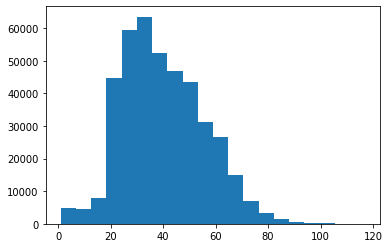

In [5]:
# Delect missing values
crash_fill = crash
crash_fill.AGE = crash_fill.AGE.fillna(-1)
crash_demiss = crash_fill.drop(crash_fill[(crash_fill.AGE>=118) | (crash_fill.AGE<=0)].index)
#print(crash_demiss.isna().sum())
plt.hist(crash_demiss.AGE,bins=20)
plt.show()

In addition to the numerical variable 'AGE', which has missing values, actually, there are two types of categorical variables that also have missing values. They are 'INVEHICLETYPE' and 'LICENSEPLATESTATE'. We also delete these None categorical rows.

In [6]:
# missing value -- Categorical
print(crash_demiss.INVEHICLETYPE.unique())
print(crash_demiss.LICENSEPLATESTATE.unique())

['Passenger Car/automobile' 'Firearms' 'Suv (sport Utility Vehicle)'
 'Large/heavy Truck' 'Other Vehicle' 'Motor Cycle' 'Passenger Van'
 'Cargo Van' 'Bus' 'None' 'Other Small/light Truck' 'Pickup Truck'
 'Atv (all Terrain Vehicle)' 'Moped/scooter' 'Drugs/ Narcotics'
 'Construction/industrial Equipment' 'Trailer' 'Farm Equipment'
 'Motorhome/camper/rv (recreational Vehicle)' 'Snow Mobile'
 'Watercraft/boat' 'Aircraft']
['MD' 'DC' 'CA' 'VA' 'IN' 'US' 'NC' 'Ot' ' None' 'TX' 'NY' 'IL' 'WV' 'OH'
 'PA' 'UT' 'NJ' 'CT' 'AZ' 'SC' 'Di' 'FL' 'KY' 'LA' 'AL' 'GA' 'DE' 'OK'
 'Un' 'MA' 'MN' 'TN' 'MO' 'CO' 'MI' 'VT' 'ID' 'KS' 'NH' 'OR' 'MS' 'AR'
 'Ou' 'ME' 'ND' 'WA' 'WI' 'AK' 'NM' 'Vi' 'IA' 'RI' 'NE' 'NV' 'WY' 'SD'
 'MT' 'HI']


In [7]:
# Delect 'None' INVEHICLETYPE and ' None' LICENSEPLATESTATE
crash_de = crash_demiss
crash_de = crash_de.drop(crash_de[(crash_de.INVEHICLETYPE=='None')].index)
crash_de = crash_de.drop(crash_de[(crash_de.LICENSEPLATESTATE==' None')].index)
Fatal_de = crash_de.loc[:,['FATAL', 'MAJORINJURY', 'MINORINJURY',]]
Fatal_de = Fatal_de['FATAL']+Fatal_de['MAJORINJURY']+Fatal_de['MINORINJURY']
features_de = crash_de.loc[:,['PERSONTYPE', 'AGE', 'INVEHICLETYPE',
       'TICKETISSUED', 'LICENSEPLATESTATE', 'IMPAIRED', 'SPEEDING']]

### 2.2. EDA

Exploratory data analysis is a step to clean the data, describe the data, compare the relationship between the data so that we can have a intuition of the data and summarize them. In this part, we analyze the relationship between features and target variable and do some transform and encode.

col_0          NNN    NNY   NYN  YNN
PERSONTYPE                          
Bicyclist       65     56    16    0
Driver      300152  33442  6489  193
Passenger    39073   9648   386   25
Pedestrian      22      6     2    0


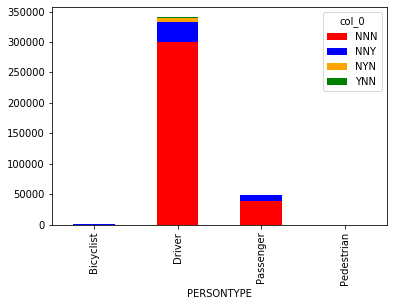

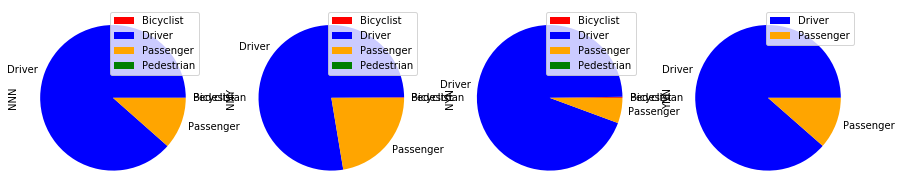

In [8]:
# EDA
# PERSONTYPE and FATAL
persontype_fatal = pd.crosstab(features_de.PERSONTYPE, Fatal_de)
print(persontype_fatal)
persontype_fatal.plot.bar(stacked=True, color=['red','blue','orange','green'])
persontype_fatal.plot.pie(subplots=True, figsize=(15,15),colors=['red','blue','orange','green'])
plt.show()

We can see that the dataset is very imbalanced. 'Driver' occupies the most part for all categories of the target, while 'Bicyclist' and 'Pedestrian' holds very small part for all categories of the target. But we can still see that in the most time, there will be no body get injured. If injured, passengers who get minor injured are more than those who get major injured or fatal. Bicyclist and pedestrain are seldom get fatal injure.

    NNN   NNY  NYN  YNN
0  50.0   NaN  NaN  NaN
3  81.0   NaN  NaN  NaN
6   NaN  51.0  NaN  NaN
7  25.0   NaN  NaN  NaN
8   NaN  27.0  NaN  NaN


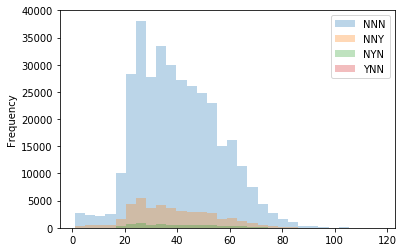

In [9]:
# AGE and FATAL
age_NNN = features_de[Fatal_de=='NNN']['AGE']
age_NNY = features_de[Fatal_de=='NNY']['AGE']
age_NYN = features_de[Fatal_de=='NYN']['AGE']
age_YNN = features_de[Fatal_de=='YNN']['AGE']
age_fatal = pd.concat([age_NNN,age_NNY,age_NYN,age_YNN],axis=1)
age_fatal.columns=['NNN','NNY','NYN','YNN']
print(age_fatal.head())
age_fatal.plot(kind='hist',bins=30,alpha=0.3)
plt.show()

For feature 'AGE', we can see that for all four categories target, most value focus on age between 20 and 40. Age between 40 and 60 are a little bit less. There are only few when age less than 20 or larger than 80. We transfer age to categorical data, to split them into four categories, 0-20, 20-35, 35-60, >60, representing teenager, youth,  middle-aged, and old people.

In [10]:
# Transfer Age to Categorical data
features_de['AGE_0_20'] = features_de[features_de.AGE<20]['AGE']
features_de['AGE_20_35'] = features_de[(features_de.AGE>=20) & (features_de.AGE<35)]['AGE']
features_de['AGE_35_60'] = features_de[(features_de.AGE>=35) & (features_de.AGE<60)]['AGE']
features_de['AGE_60_'] = features_de[features_de.AGE>=60]['AGE']
features_de['AGE_0_20'][features_de['AGE_0_20'].notna()]='1'
features_de['AGE_0_20'] = features_de['AGE_0_20'].fillna('0')
features_de['AGE_20_35'][features_de['AGE_20_35'].notna()]='1'
features_de['AGE_20_35'] = features_de['AGE_20_35'].fillna('0')
features_de['AGE_35_60'][features_de['AGE_35_60'].notna()]='1'
features_de['AGE_35_60'] = features_de['AGE_35_60'].fillna('0')
features_de['AGE_60_'][features_de['AGE_60_'].notna()]='1'
features_de['AGE_60_'] = features_de['AGE_60_'].fillna('0')
features_de['AGE_oh'] = features_de['AGE_0_20'] + features_de['AGE_20_35'] + features_de['AGE_35_60'] + features_de['AGE_60_']

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher

col_0      NNN    NNY   NYN  YNN
AGE_oh                          
>60      41180   4638   844   31
35-60   158590  18416  3093   96
20-35   123627  17438  2708   80
0-20     15915   2660   248   11


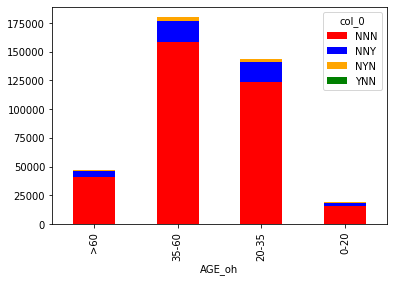

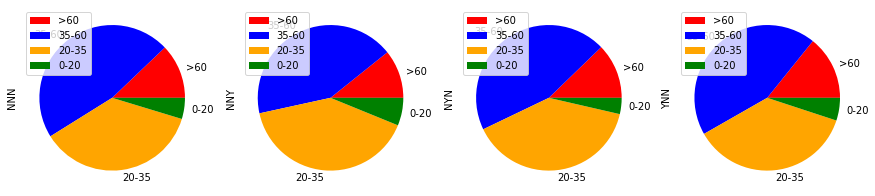

In [11]:
# EDA
# AGE and FATAL (after categorized)
age_fatal = pd.crosstab(features_de.AGE_oh, Fatal_de)
age_fatal.rename(index={'0001':'>60','0010':'35-60','0100':'20-35','1000':'0-20'},inplace=True)
print(age_fatal)
age_fatal.plot.bar(stacked=True, color=['red','blue','orange','green'])
age_fatal.plot.pie(subplots=True, figsize=(15,15),colors=['red','blue','orange','green'])
plt.show()

We view the age after categorizing. The figures show that there are little difference between the four categories targets for different age. So, age might not be a very important feature influencing the target.
Then, we check the relationship between ticket issued and target. And the plots indicate that if a person is issued a ticket, it is more possible for them to get fatal injure.

col_0            NNN    NNY   NYN  YNN
TICKETISSUED                          
N             271382  34713  6487  184
Y              67930   8439   406   34


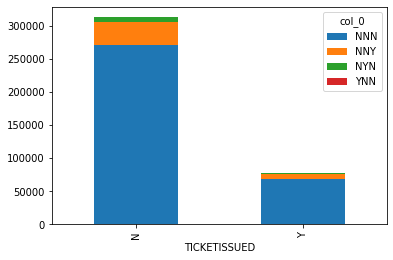

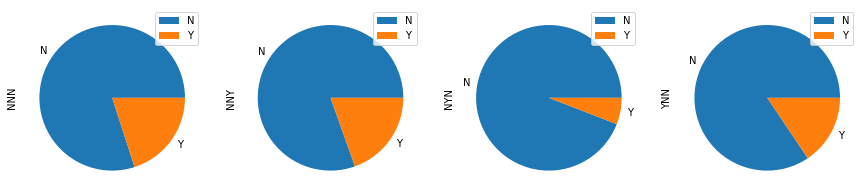

In [12]:
# TICKETISSUED and FATAL
ticketissued_fatal = pd.crosstab(features_de.TICKETISSUED, Fatal_de)
ticketissued_fatal.rename(index={0:'N',1:'Y'},inplace=True)
print(ticketissued_fatal)
ticketissued_fatal.plot.bar(stacked=True)
ticketissued_fatal.plot.pie(subplots=True, figsize=(15,15))
plt.show()

col_0        NNN    NNY   NYN  YNN
IMPAIRED                          
N         335846  42629  6822  216
Y           3466    523    71    2


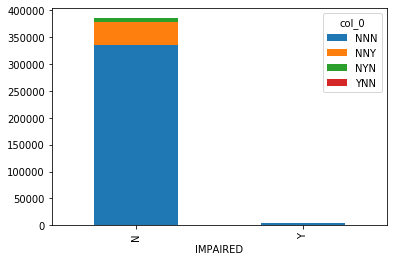

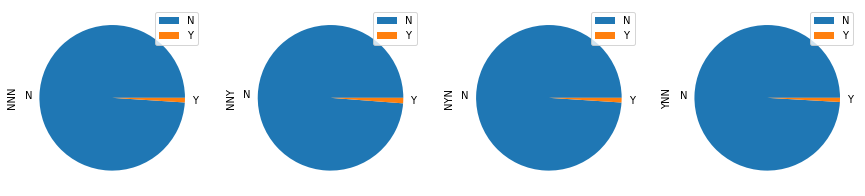

In [13]:
# IMPAIRED and FATAL
impaired_fatal = pd.crosstab(features_de.IMPAIRED, Fatal_de)
impaired_fatal.rename(index={0:'N',1:'Y'},inplace=True)
print(impaired_fatal)
impaired_fatal.plot.bar(stacked=True)
impaired_fatal.plot.pie(subplots=True, figsize=(15,15))
plt.show()

col_0        NNN    NNY   NYN  YNN
SPEEDING                          
N         336989  42638  6707  179
Y           2323    514   186   39


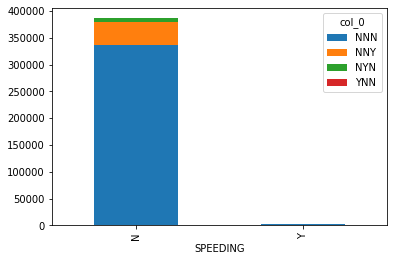

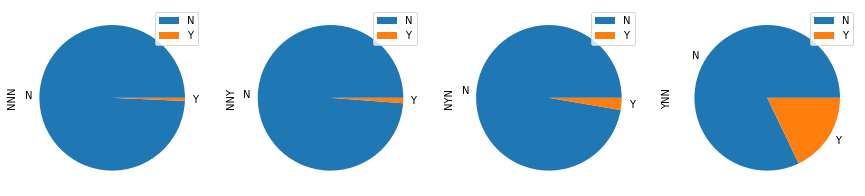

In [14]:
# SPEEDING and FATAL
speeding_fatal = pd.crosstab(features_de.SPEEDING, Fatal_de)
speeding_fatal.rename(index={0:'N',1:'Y'},inplace=True)
print(speeding_fatal)
speeding_fatal.plot.bar(stacked=True)
speeding_fatal.plot.pie(subplots=True, figsize=(15,15))
plt.show()

For 'IMPAIRED' and 'FATAL', the four categorical target almost have the same figures for 'IMPAIRED' feature. Thus, this feature might do not have effect on the target. For 'SPEEDING' and 'FATAL', we can see that there are large difference between the four categories. If the person in vehicle was indicated as speeding, then they are more likely to get fatal injure, then to get major injure, then to get minor injure, and very small likely to get no injure. Therefore, this feature might be a very important effect on target.

Now, all features are categorical variables, it is better to encode them into numerical one. At the same time, these categorical data don't have quantity relationship within each feature. So, they are also encoded into one-hot encoder. Finally, we get total of 389575 data.

In [16]:
# Encode categorical data
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder()
features_new = features_de[['PERSONTYPE', 'INVEHICLETYPE', 'TICKETISSUED','LICENSEPLATESTATE', 'IMPAIRED', 'SPEEDING','AGE_oh']]
features_new['PERSONTYPE'] = label_encoder.fit_transform(features_de['PERSONTYPE'])
features_new['AGE_oh'] = label_encoder.fit_transform(features_de['AGE_oh'])
features_new['INVEHICLETYPE'] = label_encoder.fit_transform(features_de['INVEHICLETYPE'])
features_new['TICKETISSUED'] = label_encoder.fit_transform(features_de['TICKETISSUED'])
features_new['LICENSEPLATESTATE'] = label_encoder.fit_transform(features_de['LICENSEPLATESTATE'])
features_new['IMPAIRED'] = label_encoder.fit_transform(features_de['IMPAIRED'])
features_new['SPEEDING'] = label_encoder.fit_transform(features_de['SPEEDING'])
print(features_new.head())
features_oh = onehot_encoder.fit_transform(features_new).toarray()
features_oh.shape

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

   PERSONTYPE  INVEHICLETYPE  TICKETISSUED  LICENSEPLATESTATE  IMPAIRED  \
0           1             14             0                 21         0   
3           1             14             0                 21         0   
6           1             14             0                  7         0   
7           1             14             1                 21         0   
8           1             14             0                  4         0   

   SPEEDING  AGE_oh  
0         0       1  
3         0       0  
6         0       1  
7         0       2  
8         0       2  


(389575, 92)

In [18]:
Fatal_new = Fatal_de
Fatal_new = label_encoder.fit_transform(Fatal_new)
Fatal_new = pd.DataFrame(Fatal_new)
#print(Fatal_new.head())
Fatal_oh = onehot_encoder.fit_transform(Fatal_new).toarray()
Fatal_oh.shape

(389575, 4)

### 2.3. Hyperparameter Tuning and Model Selected

In this part, several models are tried to predict target, including random forest model, random forest model after adjusting , and banlanced random forest model. I also tried some methods to deal with the problem of imbalanced data, like giving different weight to different categories, and using model from imblearn package.

First of all, we split dataset into train set and test set, where 'stratify' is added in order that the dataset can be splited according to different categories. This is in case that the categories, like fatal injured, are all divided into train or test set.

In [24]:
# Splite dataset
SEED = 42

x = features_de[['PERSONTYPE', 'INVEHICLETYPE', 'TICKETISSUED','LICENSEPLATESTATE', 'IMPAIRED', 'SPEEDING','AGE_oh']]
y = Fatal_de

x_train, x_test, y_train, y_test = train_test_split(features_new, Fatal_new, random_state=SEED, test_size=0.2, stratify=Fatal_new)

In [35]:
# Basic Random Forest Model
rf = RandomForestClassifier(n_estimators=300, max_depth=60, min_samples_leaf=5, n_jobs=-1, random_state=SEED)
rf.fit(x_train, y_train)

pred = rf.predict(x_test)

print(metrics.accuracy_score(y_test, pred))
print(metrics.classification_report(y_test, pred))
print(rf.feature_importances_)
print(metrics.f1_score(pred,y_test,average='macro'))

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.8712699736892767
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     67862
           1       0.63      0.00      0.01      8630
           2       0.00      0.00      0.00      1379
           3       0.00      0.00      0.00        44

    accuracy                           0.87     77915
   macro avg       0.38      0.25      0.24     77915
weighted avg       0.83      0.87      0.81     77915

[0.28433523 0.43867909 0.02112625 0.16711277 0.00572666 0.0230994
 0.05992059]
0.23515936783267968


/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


First of all, we use the basic random forest model from sklearn package. We can see from the results above that the accuracy is 0.87, which is high. However, due to imbalanced data, we can notice that in classification report table, precision of category 0 ('NNN') and category 1 ('NNY') are high while the other two categories are almost 0. Now that the there is imbalanced problem, its better to use fi score as the metrics instead of accuracy. Here f1-score is only 0.24 as whole, which is very low. And categoty 0 has a 0.93 f1-score, while other categories are all close to 0. All these are reuslted from imbalanced problem. Therefore, we use SMOTE method to deal with this issue.

In [36]:
# Imbalanced Data
f = Fatal_de
zz=np.array(f)
print(np.unique(zz,return_counts=True))

sm = SMOTE(random_state=SEED, n_jobs=-1)
x_train_smote, y_train_smote = sm.fit_resample(x_train, y_train)
print(np.unique(np.array(y_train_smote),return_counts=True))

(array(['NNN', 'NNY', 'NYN', 'YNN'], dtype=object), array([339312,  43152,   6893,    218]))
(array([0, 1, 2, 3]), array([271450, 271450, 271450, 271450]))


In [33]:
# Random Forest Model after Adjusting Imbalanced
rf2 = RandomForestClassifier(n_estimators=300, max_depth=60, min_samples_leaf=5, n_jobs=-1, random_state=SEED)
rf2.fit(x_train_smote, y_train_smote)

pred2 = rf2.predict(x_test)

print(metrics.accuracy_score(y_test, pred2))
print(metrics.classification_report(y_test, pred2))
print(metrics.f1_score(pred2,y_test,average='macro'))
print(rf2.feature_importances_)

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.18952704870692422
              precision    recall  f1-score   support

           0       0.93      0.16      0.27     67862
           1       0.17      0.35      0.23      8630
           2       0.03      0.60      0.05      1379
           3       0.00      0.30      0.00        44

    accuracy                           0.19     77915
   macro avg       0.28      0.35      0.14     77915
weighted avg       0.83      0.19      0.26     77915

0.13742365204466558
[0.14666269 0.33512633 0.14901904 0.19625268 0.00625744 0.07513689
 0.09154492]


From the above result of random forest model after adjusting imbalanced problem, we can see that the number of four categories are resample from 339312, 43152, 6893, 218 respectively to 271450 each. Although f1-score of category 1 and category 2 both increase. But after processing this method, the whole f1-score decreases from 0.24 to 0.14. Then, we try to define a function to give different weights to each category, larger weight to small category and small weight to large category so that the machine can learn to classify the data consider more about small number of class.

In [52]:
# Dealing with Imbalanced Data by Defining a Function
def create_class_weight(labels_dict,mu=0.15):
  total = np.sum(list(labels_dict.values()))
  keys = labels_dict.keys()
  class_weight = dict()
    
  for key in keys:
      score = math.log(mu*total/float(labels_dict[key]))
      class_weight[key] = score if score > 0.0 else 0.1
    
  return class_weight

nNNN = np.unique(y_train[(y_train==0)].values,return_counts=True)
nNNY = np.unique(y_train[(y_train==1)].values,return_counts=True)
nNYN = np.unique(y_train[(y_train==2)].values,return_counts=True)
nYNN = np.unique(y_train[(y_train==3)].values,return_counts=True)
labels_dict = {0:nNNN[1][0], 1:nNNY[1][0], 2:nNYN[1][0], 3:nYNN[1][0]}

class_weights = create_class_weight(labels_dict)

In [53]:
rf3 = RandomForestClassifier(n_estimators=300, max_depth=60, min_samples_leaf=5, n_jobs=-1, class_weight=class_weights,random_state=SEED)
rf3.fit(x_train, y_train)

pred3 = rf3.predict(x_test)

print(metrics.accuracy_score(y_test, pred3))
print(metrics.classification_report(y_test, pred3))
print(metrics.f1_score(pred3,y_test,average='macro'))
print(rf3.feature_importances_)

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.8569851761535006
              precision    recall  f1-score   support

           0       0.88      0.98      0.92     67862
           1       0.26      0.03      0.05      8630
           2       0.09      0.07      0.08      1379
           3       0.05      0.05      0.05        44

    accuracy                           0.86     77915
   macro avg       0.32      0.28      0.28     77915
weighted avg       0.79      0.86      0.81     77915

0.2774873489137214
[0.16869572 0.34053247 0.18135603 0.1843879  0.0093863  0.05874844
 0.05689314]


After giving weights to different classes. We notice that f1-score of category 4 finally larger than 0. F-1 score for the whole model is 0.28. Although it is still very small, but it is a little bit larger than before. 

We also did a balanced bagging classifier model. But the f-1 score is only 1.3 as a whole, and f-1 score of each category are not very high, less than 0.3. Thus, it is not listed.

### 2.4. Interpretation

Comparing f-1 score of the models we did, the model given weight for each category has the best result. So, this can be selected as a best predictive model. However, actually, the f-1 score is still very small. This is most likely because the data is still not perfect, in the other words, imbalanced problem is still exist. Thus, it is better to find other methods to deal with this issue in the future.

What's more, the importance of each feature also be generated for the above models. It is clear that type of vehicle has the highest score in all three models. Thus, it is a important effect on the severity level. Then, the state plating the driver license, whether a person was issued a ticket, and type of person are also have relatively high score. so, they are also important factors that have influence on severity level. The score of whether a person in vehicle where speeding was indicated, and the age of the person are not very high, not larger than 0.1. Therefore, these variables might have little effect on target variable. Finally, if any persons deemed ‘impaired’ almost has no effect on severity level.

## 3. Discussion

Based on the finding of this report, we can say that the type of vehicle has the very important effect on the severity level. This is also be confirmed by some article. For example, Shengdi Chen, Shiwen Zhang (2020) claimed that more serious casualties would happen if a truck crash happens due to the high vehicle weight, long vehicle length, and poor stopping distance. So, people who need to drive high-risk types of vehicles, like trucks, should accept more stringent assessments and training before they can obtain the diver licenses.

The state plating the driver license also has a important influence on severity level. This may have a certain relationship with the differences in the driver's license assessment system and traffic regulations of each state. In some states, it is easier to pass the driver’s license test. The traffic regulations of different states have different requirements for drivers and passengers, such as the regulations on seat belts. The enactment of relevant laws may reduce the degree of injuries in traffic accidents. For example, Fredrick M. Streff (1990) pointed out that Michigan’s adult seat belt laws prevented 31,710 injuries from being injured from July 1985 to December 1988.

Different type of person also get different level injured in crash. Combined with our study, it also has important influence on severity level in a traffic crash. Some articles also support this idea. For instance, Isaksson Hellman (2012) said that bicyclists constitute the highest percentage of severely injured compared to other road user group.

### Reference:

Chen, S., Zhang, S., Xing, Y., & Lu, J. (2020). Identifying the Factors Contributing to the Severity of Truck-Involved Crashes in Shanghai River-Crossing Tunnel. International Journal of Environmental Research and Public Health, 17(9), 3155. doi:10.3390/ijerph17093155
Streff, F. M., Wagenaar, A. C., & Schultz, R. H. (1990). Reductions in police-reported injuries associated with Michigans safety belt law. Journal of Safety Research, 21(1), 9-18. doi:10.1016/0022-4375(90)90043-b
Isaksson-Hellman, I. (2012). A study of bicycle and passenger car collisions based on insurance claims data. Retrieved from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3503407/